In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import tensorflow as tf


In [9]:
# Data Cleaning

# Load our megadata
file_path = 'JinjiangBooks.csv'
data = pd.read_csv(file_path)

# Fill missing numeric values with 0, so that no NaN values can affect further calculations or model performance.
num_cols = ['NonVIP_average_click', 'reviews_num', 'collected_num', 'nutrient_num', 'credits', 'progress', 'contract_status', 'total_word_count']
data[num_cols] = data[num_cols].fillna(0)

# Fill missing categorical values with 'NONE' to maintain data integrity for analysis.
cat_cols = ['genre', 'perspective']
data[cat_cols] = data[cat_cols].fillna('NONE')

# Standardize date entries, replacing errors and missing values with a placeholder for uniformity.
data['chapter_launch_time'] = data['chapter_launch_time'].replace('Error', '0000-00-00 00:00:00').fillna('0000-00-00 00:00:00')

# Decompose the 'genre' column into subcategories and handle missing values within the decomposed data.
data['genre'] = data['genre'].fillna('无-无-无-无')
expanded_genres = data['genre'].str.split('-', expand=True)
genre_columns = ['top_genre', 'sub_genre1', 'sub_genre2', 'sub_genre3']
for i, col in enumerate(genre_columns):
    data[col] = expanded_genres[i].fillna('无') if i < expanded_genres.shape[1] else '无'

# Apply one-hot encoding to newly created categorical columns for model-readiness.
data = pd.get_dummies(data, columns=genre_columns)

# Handle 'perspective' column by filling missing values and applying one-hot encoding.
data['perspective'] = data['perspective'].fillna('无')
perspective_dummies = pd.get_dummies(data['perspective'], prefix='perspective')
data = pd.concat([data, perspective_dummies], axis=1)
data.drop('perspective', axis=1, inplace=True)

# Identify and handle non-numeric entries in the 'credits' column.
invalid_credits = pd.to_numeric(data['credits'], errors='coerce').isna()
#print(data[invalid_credits])
data.loc[invalid_credits, 'credits'] = 0
data['credits'] = pd.to_numeric(data['credits'])

# Convert 'chapter_launch_time' to a numeric feature that counts days from the earliest date.
data['chapter_launch_time'] = pd.to_datetime(data['chapter_launch_time'], errors='coerce')
min_date = data['chapter_launch_time'].min()
data['days_from_min_date'] = (data['chapter_launch_time'] - min_date).dt.days
data.drop('chapter_launch_time', axis=1, inplace=True)

# Remove less relevant or personal identifying information for privacy or simplicity.
data.drop(['book_name', 'author', 'book_id'], axis=1, inplace=True)

# Save the cleaned data to a new CSV file. This is the file we are going to load from this point on.
output_file_path = 'processed_data.csv'
data.to_csv(output_file_path, index=False, encoding='utf-8-sig')
print(f"Data has been successfully saved to {output_file_path}")


Data has been successfully saved to processed_data.csv


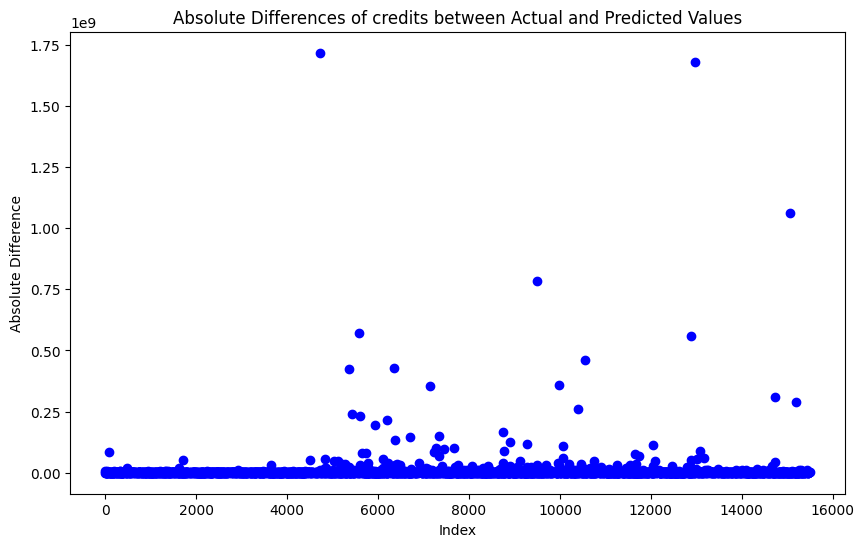

In [ ]:
# Baseline Model: Linear Regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

file_path = 'processed_data.csv'  # Ensure this is the correct path to your data file
data = pd.read_csv(file_path)

# Filtering outliers: to focues on where 'NonVIP_average_click' is larger than 10
filtered_data = data[data['NonVIP_average_click'] > 10]

# Select 'NonVIP_average_click' and 'credits' as features for clustering
features_for_clustering = filtered_data[['NonVIP_average_click', 'credits']]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

# Using KMeans algorithm for clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
filtered_data['cluster'] = kmeans.fit_predict(features_scaled)

# Calculate statistics for each cluster and find the largest cluster
cluster_stats = filtered_data.groupby('cluster').agg(count=('NonVIP_average_click', 'count')).reset_index()
largest_cluster = cluster_stats.loc[cluster_stats['count'].idxmax(), 'cluster']
largest_cluster_data = filtered_data[filtered_data['cluster'] == largest_cluster]
X = data.drop(['NonVIP_average_click', 'credits'], axis=1)
y = data['NonVIP_average_click']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Establish，train and predict
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluate 
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)  

print(f"Test MSE: {mse}")
print(f"Test R²: {r2}")

# Predictions, ensuring the output is one-dimensional
y_pred = model.predict(X_test_scaled).flatten()

import matplotlib.pyplot as plt

# Calculate absolute differences between actual and predicted values
differences = abs(y_test - y_pred)

# Create a plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, differences, color='blue')
plt.title('Absolute Differences between Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Absolute Difference')
plt.ylim(-100, 50000) 
plt.show()


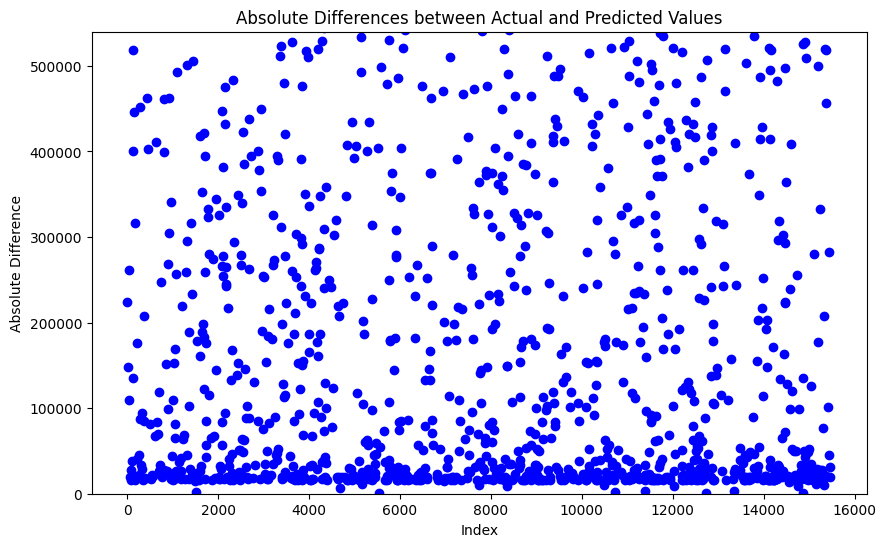

In [ ]:
# Model 2: Random Forest

file_path = 'processed_data.csv'
data = pd.read_csv(file_path)

# Filtering outliers: to focus on where 'NonVIP_average_click' is larger than 10
filtered_data = data[data['NonVIP_average_click'] > 10]

# Select features: based on 'NonVIP_average_click' and 'credits'
features_for_clustering = filtered_data[['NonVIP_average_click', 'credits']]

# Normalize features for clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

# Apply KMeans clustering with 5 clusters to segment the data; aggregate to find the cluster with most records
kmeans = KMeans(n_clusters=5, random_state=42)
filtered_data['cluster'] = kmeans.fit_predict(features_scaled)
cluster_stats = filtered_data.groupby('cluster').agg(count=('NonVIP_average_click', 'count')).reset_index()
largest_cluster = cluster_stats.loc[cluster_stats['count'].idxmax(), 'cluster']

# Filter data to include only entries from the largest cluster
largest_cluster_data = filtered_data[filtered_data['cluster'] == largest_cluster]
X = largest_cluster_data.drop(['NonVIP_average_click', 'credits'], axis=1)  # Feature set
y = largest_cluster_data['NonVIP_average_click']  # Target variable

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Re-scale features for model input using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest model with 100 trees
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)  # Calculate R-squared for performance

print(f"Test MSE: {mse}")
print(f"Test R²: {r2}")

# Flatten predictions for consistency and further analysis
y_pred = model.predict(X_test_scaled).flatten()

# Calculate the absolute differences between actual and predicted values
differences = abs(y_test - y_pred)

# Plot the absolute differences to visually assess model performance
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, differences, color='blue')
plt.title('Absolute Differences between Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Absolute Difference')
plt.ylim(-100, 50000)  # Set y-axis range for better visualization
plt.show()


In [6]:
# Model 3: Neural Network 

file_path = 'processed_data.csv'
data = pd.read_csv(file_path)

# Filtering outliers: to focues on where 'NonVIP_average_click' is larger than 10
filtered_data = data[data['NonVIP_average_click'] > 10]

# Features for clustering:
features_for_clustering = filtered_data[['NonVIP_average_click', 'credits']]

# Standardize features to have mean = 0 and variance = 1 for better performance in clustering and neural networks
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

# Apply KMeans clustering with 5 clusters; aggregate to find the cluster with most records
kmeans = KMeans(n_clusters=5, random_state=42)
filtered_data['cluster'] = kmeans.fit_predict(features_scaled)
cluster_stats = filtered_data.groupby('cluster').agg(count=('NonVIP_average_click', 'count')).reset_index()
largest_cluster = cluster_stats.loc[cluster_stats['count'].idxmax(), 'cluster']

# Select data from the largest cluster for further analysis
largest_cluster_data = filtered_data[filtered_data['cluster'] == largest_cluster]

# Prepare features (X) and target (y)
X = largest_cluster_data.drop(['NonVIP_average_click', 'credits'], axis=1)
y = largest_cluster_data['NonVIP_average_click']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reapply standardization to feature data for neural network input
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # First hidden layer with 128 neurons
    tf.keras.layers.Dense(64, activation='relu'),  # Second hidden layer with 64 neurons
    tf.keras.layers.Dense(1)  # Output layer for regression output
])

# Compile the model with the Adam optimizer and mean squared error as the loss function
model.compile(optimizer='adam', loss='mse')

# Train the model for 50 epochs with a validation split of 20% to monitor overfitting
model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model using mean squared error and R-squared metrics
mse = model.evaluate(X_test_scaled, y_test)
mae = model.evaluate(X_test_scaled)
r2 = r2_score(y_test, y_pred.flatten()) 

# Print out the performance metrics
print(f"Neural Network performance matric")
print(f"Test MSE: {mse}")
print(f"Test R²: {r2}")

differences = abs(y_test - y_pred)
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, differences, color='blue')
plt.title('Absolute Differences between Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Absolute Difference')
plt.show()


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Further analysis performed on Random Forest
# Filtering feature to show NonVIP_average_click >10 
# K-means Clustering: k = 3
# One Decision Tree

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# 加载数据
file_path = 'processed_data.csv'
data = pd.read_csv(file_path)

# 过滤数据
filtered_data = data[(data['NonVIP_average_click'] > 10)]

# 标准化特征
scaler = StandardScaler()
features_for_clustering = filtered_data[['NonVIP_average_click', 'credits']]
features_scaled = scaler.fit_transform(features_for_clustering)

# KMeans 聚类
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
filtered_data['cluster'] = kmeans.fit_predict(features_scaled)

# 选择最大簇
cluster_stats = filtered_data.groupby('cluster').agg(count=('NonVIP_average_click', 'count')).reset_index()
largest_cluster = cluster_stats.loc[cluster_stats['count'].idxmax(), 'cluster']
largest_cluster_data = filtered_data[filtered_data['cluster'] == largest_cluster]

# 准备数据
X = largest_cluster_data.drop(['NonVIP_average_click', 'credits'], axis=1)
y = largest_cluster_data['NonVIP_average_click']

# 标准化 X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 设置 K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 随机森林模型
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 使用 K-Fold 进行交叉验证
mse_scores = cross_val_score(model, X_scaled, y, cv=kfold, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_scaled, y, cv=kfold, scoring='r2')

# 将 MSE 分数转换为正值（因为 cross_val_score 返回负的 MSE）
mse_scores = -mse_scores

print("MSE scores for each fold:", mse_scores)
print("Average MSE:", mse_scores.mean())
print("R² scores for each fold:", r2_scores)
print("Average R²:", r2_scores.mean())


C:\Users\aaqqi\AppData\Local\Temp\ipykernel_29800\2207981436.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['cluster'] = kmeans.fit_predict(features_scaled)


MSE scores for each fold: [ 7068044.54755345 10608554.18354652  6121813.11992536  7811594.39032592
 10412572.01525727]
Average MSE: 8404515.651321704
R² scores for each fold: [0.87772796 0.79920202 0.88404796 0.83089972 0.78702552]
Average R²: 0.8357806345931185
